# New and Improved Titanic Classification Project

## Introduction

Earlier in my Project Portfolio's history, I created a Machine Learning algorithm to predict the survivors of the Titanic using datasets from the Kaggle competition by the same name. However, this project was created in the early stages of my Machine Learning "learning" curve (pun intended).

This time, I'm back for a second try with all of the additional knowledge of an employment ready ML Engineer (i.e, feature engineering, cross validation, hyperparameter optimization, etc.) 

The goal of this project is simple: beat my old model's score of 76%. Let's get to it.

### Preprocessing

In [1]:
# We first import all of our necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# We then read in our training and holdout sets provided by kaggle
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
# We print out the first few rows of our dataset to see what it looks like
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Functions for Feature Engineering

We will first create several function that will aid our efforts in crafting the best possible columns. The comments associated with each function will describe exactly what each column is designed to accomplish.

Function purposes range from creating dummy variables based upon categorical columns to creating new columns all-together from text in existing columns.


In any event, we will indicate when we apply each function to our training and holdout dataframes to indicate we are returning a new dataframe. 

In [4]:
# First, we create a function to help replace the missing values of a column
def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

In [5]:
# We then create a function that groups our age into categories for a new column
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)  # Fills NaN values
    cut_points = [-1,0,5,12,18,35,60,100]  # Split our ages into bins
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]  # Create categorical labels
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)  # Creates a new column with new categories
    return df

In [6]:
# We then create a function that crafts dummy variable columns and appends to original Dataframe
def create_dummies(df,column_name):  # Takes a dataframe and column as input
    dummies = pd.get_dummies(df[column_name],prefix=column_name)  
    df = pd.concat([df,dummies],axis=1)  # Appends new columns to OG dataframe
    return df

In [7]:
# We then create a function that groups our fare prices as categories
def process_fare(df):  # Same concept as process_age
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

In [8]:
def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]  # Extract the first word of the column...cabin location
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")  # Fill missing values
    df = df.drop('Cabin',axis=1)  # Drop the original Dataframe
    return df

In [9]:
# This function renames and regroups the title columns
def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }  # Mapping for the title column
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

### Feature Engineering

We now apply the functions we created above to our dataframes via function...it's function-ception.

In [10]:
def feature_engineering(df):
    # Each of the functions above is applied below
    df = process_missing(df)  
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    # We only wish to create dummy variables for these select columns
    dummy_cols = ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]
    for col in dummy_cols:
        df = create_dummies(df, col)
    return df

In [11]:
# We feature engineer our original dataframe
clean_train = feature_engineering(train)

In [12]:
# We feature engineer our holdout dataframe
clean_holdout = feature_engineering(holdout)

### Exploratory Analysis

We wish to take a closer look at the information pertaining to each family member aboard the ship at the time of its sinking. This data is contained in the SibSp and Parch columns

In [13]:
# First, we'll take a look at the distribution of each of these columns
sibling_dist = pd.Series(clean_train["SibSp"].value_counts())
sibling_dist

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [14]:
parch_dist = pd.Series(clean_train["Parch"].value_counts())
parch_dist

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [15]:
# We then create a sibling Dataframe to house our values
data_dict = {"SibSp": clean_train["SibSp"], "Parch": clean_train["Parch"]}
sibling_df = pd.DataFrame(data_dict)

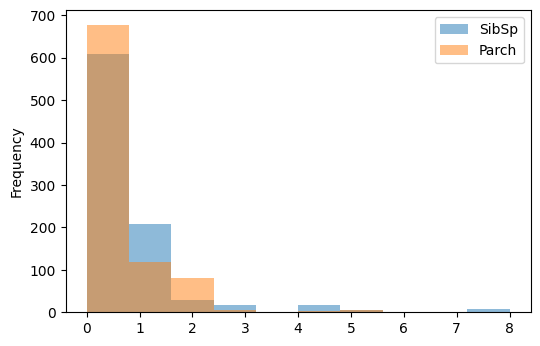

In [16]:
# Let's plot a histogram to view these values better
%matplotlib inline
sibling_df.plot.hist(alpha=0.5)
plt.show()

In [17]:
# We should definitely consider scaling this data once we create our model. Let's take a look at how it relates to the survival rate
sibling_pivot = clean_train.pivot_table(index="SibSp", values="Survived")
sibling_pivot

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [18]:
# The same for the parch column
parch_pivot = clean_train.pivot_table(index="Parch", values="Survived")
parch_pivot

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


According to the dataset documentation, SibSp measures how many siblings or spouses there were at the time of the sinking where as the Parch column measures how many parents or children were aboard.

From the results of our pivot table it is clear that the fewer relatives individuals had, the more likely they were to survive. 

Most of this data is likely to overlap, so we should think of a way to create a new column that combines these two features.

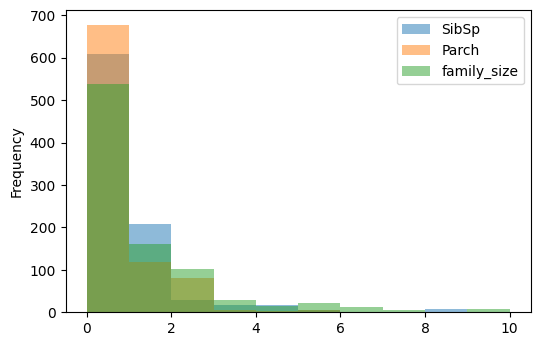

In [19]:
# Adding these two columns together would give us the family size of each individual
clean_train["family_size"] = clean_train["SibSp"] + clean_train["Parch"]
sibling_df["family_size"] = clean_train["family_size"]
sibling_df.plot.hist(alpha=0.5)

Before we commit to crafting a new feature, let's see the pivot table of the family sizes column

In [20]:
clean_train.pivot_table(index="family_size", values="Survived")

,Survived
family_size,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In general, it appears that the fewer family members a person has, the more likely they are to have survived. Let's create a new binary column in which we classify people as being alone or not.

In [21]:
def process_family(df):
    alone_column = []
    for size in df["family_size"]:
        if size == 0:
            alone_column.append(1)
        else:
            alone_column.append(0)
    df["isalone"] = alone_column
    return df

In [22]:
# Before we apply this function, let's create a family size feature for the holdout dataframe
clean_holdout["family_size"] = clean_holdout["SibSp"] + clean_holdout["Parch"]

In [23]:
clean_train = process_family(clean_train)

In [24]:
clean_holdout = process_family(clean_holdout)

### Finding the Best Features

We now proceed to my favorite part of any Machine Learning workflow: the creation of our model. We will first begin by crafting a Random Forest Classifier, but with recursive feature elimination to ensure we only choose the best columns for our model. 

By best, we mean the column that help us classify object correctly the best. 

In [25]:
# We create a function that will choose the best columns for us
def find_best_features(df):
    # First, we only select the numeric columns and drop columns containing NaN
    features = df.select_dtypes([np.number]).dropna(axis=1)
    # We then create our training and target matrix and vector
    all_X = features.drop(["PassengerId", "Survived"], axis=1)
    all_y = features["Survived"]
    # We then instantiate a RFC class and perform RFECV to find the best features
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    best = list(all_X.columns[selector.support_])
    print("The Best columns are:", best)
    return best

In [26]:
best_features = find_best_features(clean_train)

The Best columns are: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size']


### Model Construction

We now proceed to creating a Machine Learning pipeline that will help tremendously speed up the process of crafting numerous differenct models. We will create a function that trains three models, and at the same time performs hyperparameter optimization by utlizing grid search. Each model that is returned will be the best to make our holdout predictions. 

We will then save each holdout prediction and submit them to the Kaggle competition to get a score!

In [27]:
# This is a rather complex function, so comments will help explain what is going on
def select_model(df, feature_columns):  # Create a function that takes in a dataframe and a list of columns as input
    all_X = df[feature_columns]  # Creates a feature matrix
    all_y = df["Survived"]  # Creates a target vector
    model_list = [{                   # This is a list that contains a model's name, class, and hyperparameter values
        "name": "LogisticRegrssion",
        "estimator": LogisticRegression(),
        "hyperparameters": {  # Hyperparameters specific to LogisticRegression
            "solver": ["newton-cg", "lbfgs", "linblinear"]  
        }
    }, {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters": {  # Hyperparameters specific to KNeighborsClassifier
            "n_neighbors": list(range(1,20,2)),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1, 2]
        }
    }, {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters": {  # Hyperparameters specific to RandomForestClassifier
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }]
    for model in model_list:  # We then iterate over each element of our list, which is itself a dictionary. For each model:
        print(model["name"])  # We print the name of the model
        print("-----------------------------------------------")
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)  # We then perform gridsearch with the element's estimator (model class) and use the hyperparameters specific to that model
        ml_model = grid.fit(all_X, all_y)  # We then fit our Grid Search Model
        model["best_params"] = ml_model.best_params_  # We then create a new key/value pair that contains the best parameters
        model["best_score"] = ml_model.best_score_  # We then create a new ky/value pair that contains the best score
        model["best_estimator"] = ml_model.best_estimator_  # We create a new pair that has the best parameters assigned to our class
        print("For the {} model, best parameters and score are {} and {} respectively.".format(model["name"], model["best_params"], model["best_score"]))
        print("\n")
    return model_list  # We then return the list of dictionaries so we can access each model relatively easily

In [28]:
best_classifiers = select_model(clean_train, best_features)

LogisticRegrssion
-----------------------------------------------


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

For the LogisticRegrssion model, best parameters and score are {'solver': 'newton-cg'} and 0.821598002496879 respectively.


KNeighborsClassifier
-----------------------------------------------
For the KNeighborsClassifier model, best parameters and score are {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} and 0.7822971285892635 respectively.


RandomForestClassifier
-----------------------------------------------
For the RandomForestClassifier model, best parameters and score are {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6} and 0.8395505617977529 respectively.




### Submission to Kaggle

We now have 3 models to run on our holdout dataframe to generate predictions to submit to Kaggle. Each model is stored within our best classifiers list created with the function above. 

We will create a function that accepts a model as a parameter, along with a file name, that runs a prediction with our holdout dataset and saves the answers to a csv file. We will then submit 3 Kaggle predictions and record the scores we receive for each model in the Conclusion section below

In [29]:
def save_submission_file(model, features, file_name):
    holdout_features = clean_holdout[features]
    predictions = model.predict(holdout_features)
    holdout_ids = clean_holdout["PassengerId"]
    data_dict = {"PassengerId": holdout_ids, 
                "Survived": predictions}
    submission = pd.DataFrame(data_dict)
    submission.to_csv(file_name, index=False)

In [30]:
# We then will run the save_submission file 3 times for each different model
best_lr_model = best_classifiers[0]["best_estimator"]
best_knn_model = best_classifiers[1]["best_estimator"]
best_rf_model = best_classifiers[2]["best_estimator"]

In [31]:
# We then run the save_submission file function 3 times
save_submission_file(best_lr_model, best_features, "lr_predictions.csv")

In [32]:
save_submission_file(best_knn_model, best_features, "knn_predictions.csv")

In [33]:
save_submission_file(best_rf_model, best_features, "rf_predictions.csv")

## Conclusion

After submitting each model to Kaggle to receive accuracy scores, here are the results of our best trained models:

- Logistic Regresion: 76.5% accurate
- K-Nearest Neighbors: 72.7% accurate
- Random Forest Classifier: 77.2% accurate

My original model that I created a few months ago was about 76% accurate. Thus I was able to improve my score by about 1.2%, which is pretty good. Beyond achieving a better score, however, the process of learning how to streamline a machine learning workflow has been superbly beneficial to expanding my Machine Learning toolkit. 

If you're curious to see my submission score on Kaggle, feel free to check it out! My username is musicmaster81. Simply head on over to the Titanic competition leaderboard and search for my name there!